In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.colors as mcolors
import matplotlib.path as mpath
from matplotlib.ticker import MaxNLocator
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [2]:
def load_trend_data(variable, model, experiment):
    #loads in the trend data
    #factor to convert trend data from Pa/year to hPa
    conversion_factor = 1.65
    
    #slice trend to the N. Atlantic
    lat_range = slice(20, 80)
    lon_range = slice(-90, 40)
    
    filepath = f"{base_dir}/trend_calc_LESFMIP/linear_regression/NAO/{experiment}/{model}/psl_mon_{experiment}_{model}_DJF_linear_trend.nc"
    return xr.open_dataset(filepath).sel(lat=lat_range, lon=lon_range) * conversion_factor

def load_proj_or_resid_data(variable, mode, index, model, experiment):
    #loads in the projected or residual data
    filepath = f"{base_dir}/projection_indicies/NAtlantic_forced_trends/{experiment}/{model}/psl_mon_{experiment}_{model}_DJF_{index}_{mode}.nc"
    return xr.open_dataset(filepath)

def get_min_max(data_dict, variable):
    #finds the max and min values of the data
    values_min = [np.min(data[variable]) for data in data_dict.values()]
    values_max = [np.max(data[variable]) for data in data_dict.values()]
    return min(values_min), max(values_max)

# Define the model name and path template
model = ['HadGEM3-GC31-LL']
base_dir = '/gws/nopw/j04/extant/users/slbennie'

# List of forcing experiments
experiments = ['historical', 'hist-aer', 'hist-GHG', 'hist-sol', 'hist-totalO3', 'hist-volc']


for m in model:
    # Load trend data
    trend_data = {experiment: load_trend_data('psl', m, experiment) for experiment in experiments}
    
    # Load NAO projection and residual
    proj_data = {experiment: load_proj_or_resid_data('psl', 'projection', 'NAO', m, experiment) for experiment in experiments}
    residual_data = {experiment: load_proj_or_resid_data('psl', 'residual', 'NAO', m, experiment) for experiment in experiments}
    
    # Load EA projection and residual
    proj_data_EA = {experiment: load_proj_or_resid_data('psl', 'projection', 'EA', m, experiment) for experiment in experiments}
    residual_data_EA = {experiment: load_proj_or_resid_data('psl', 'residual', 'EA', m, experiment) for experiment in experiments}

#finding the min and max for each dataset to set a colour scheme for all of the plots
min_trend, max_trend = get_min_max(trend_data, 'slope')
min_proj, max_proj = get_min_max(proj_data, 'projection_NAO_djf')
min_resid, max_resid = get_min_max(residual_data, 'residual_NAO_djf')
min_proj_EA, max_proj_EA = get_min_max(proj_data_EA, 'projection_EA_djf')
min_resid_EA, max_resid_EA = get_min_max(residual_data_EA, 'residual_EA_djf')

# Overall min/max
min_all = min(min_trend, min_proj, min_resid, min_proj_EA, min_resid_EA)
max_all = max(max_trend, max_proj, max_resid, max_proj_EA, max_resid_EA)

# Color normalization
norm_all = mcolors.TwoSlopeNorm(vmin=min_all, vcenter=0, vmax=max_all)


In [3]:
# Order of data layers for rows
data_layers = [
    (trend_data, 'slope'),                      # Trend
    (proj_data, 'projection_NAO_djf'),          # Project onto NAO
    (residual_data, 'residual_NAO_djf'),        # Residual after NAO
    (proj_data_EA, 'projection_EA_djf'),        # Project residual onto EA
    (residual_data_EA, 'residual_EA_djf')       # Residual after EA
]

titles = ['historical','hist-aer','hist-GHG','hist-sol','hist-totalO3','hist-volc']

/tmp/ipykernel_562/3992766055.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,0.91,0.97])


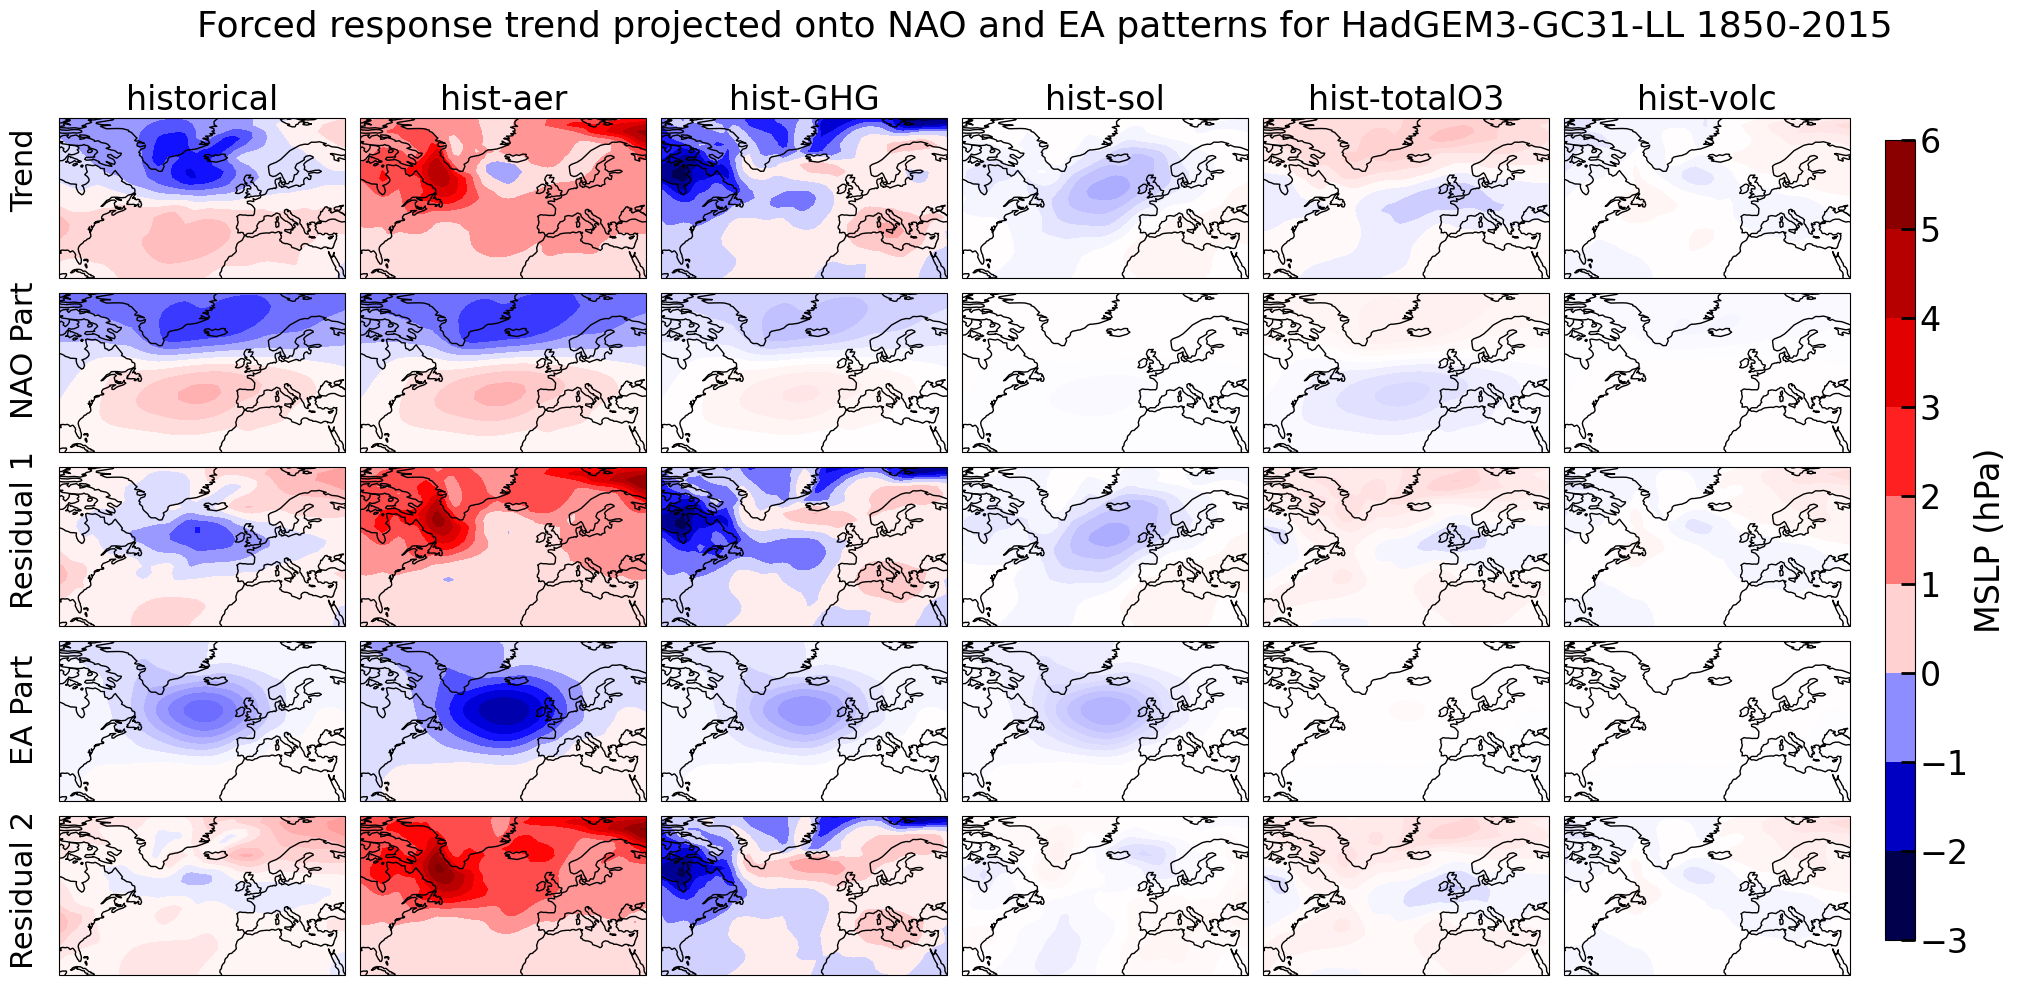

In [4]:
#PLOTTING - 5 row fig, trend, NAO part, residual 1, EA part, residual 2

fig, ax = plt.subplots(nrows=5, ncols=6, figsize=(20,10), subplot_kw={'projection': ccrs.PlateCarree()})
cmap = 'seismic'

# Dummy colorbar setup
#max_abs = np.round(max(abs(min_all), abs(max_all)),1)
#levels = np.round(np.linspace(-max_abs, max_abs, 50),1)
dummy_data = np.array([[min_all, max_all], [min_all, max_all]])
dummy_cont = ax[0, 0].contourf([0,1], [0,1], dummy_data, cmap=cmap, norm=norm_all)#, levels=levels)

# Map extent
lon_min, lon_max = -90, 40
lat_min, lat_max = 20, 80

# Plotting each row and column
for i, (data_dict, varname) in enumerate(data_layers):
    for j, experiment in enumerate(titles):
        data = data_dict[experiment]
        ax[i, j].contourf(data['lon'], data['lat'], data[varname], cmap=cmap, norm=norm_all)#, levels=levels)
        if i == 0:
            ax[i, j].set_title(experiment, fontsize=24)

# Add coastlines and formatting
for i in range(5):
    for j in range(6):
        ax[i, j].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        ax[i, j].add_feature(cfeature.COASTLINE, linewidth=1)
        ax[i, j].set_xlabel('lon', fontsize=12)
        ax[i, j].set_ylabel('lat', fontsize=12)
        ax[i, j].set_aspect('auto')

# Add colorbar
cax = fig.add_axes([0.92, 0.05, 0.015, 0.8])
cbar = fig.colorbar(dummy_cont, cax=cax)
cbar.set_label('MSLP (hPa)', fontsize=24)
cbar.ax.tick_params(direction='in', length=10, width=2, labelsize=24)
#cbar.locator = MaxNLocator(nbins=10)
#cbar.update_ticks()

# Add overall labels and title
fig.suptitle(f"Forced response trend projected onto NAO and EA patterns for {model[0]} 1850-2015", fontsize=26)
row_labels = ['Trend', 'NAO Part', 'Residual 1', 'EA Part', 'Residual 2']
for i, label in enumerate(row_labels):
    fig.text(-0.01, 0.82 - i*0.18, label, rotation=90, va='center', ha='center', fontsize=22)

plt.tight_layout(rect=[0,0,0.91,0.97])
plt.savefig(f'Forced_response_trend_proj_{model[0]}.png', bbox_inches='tight')
plt.show()


/tmp/ipykernel_562/2082453839.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


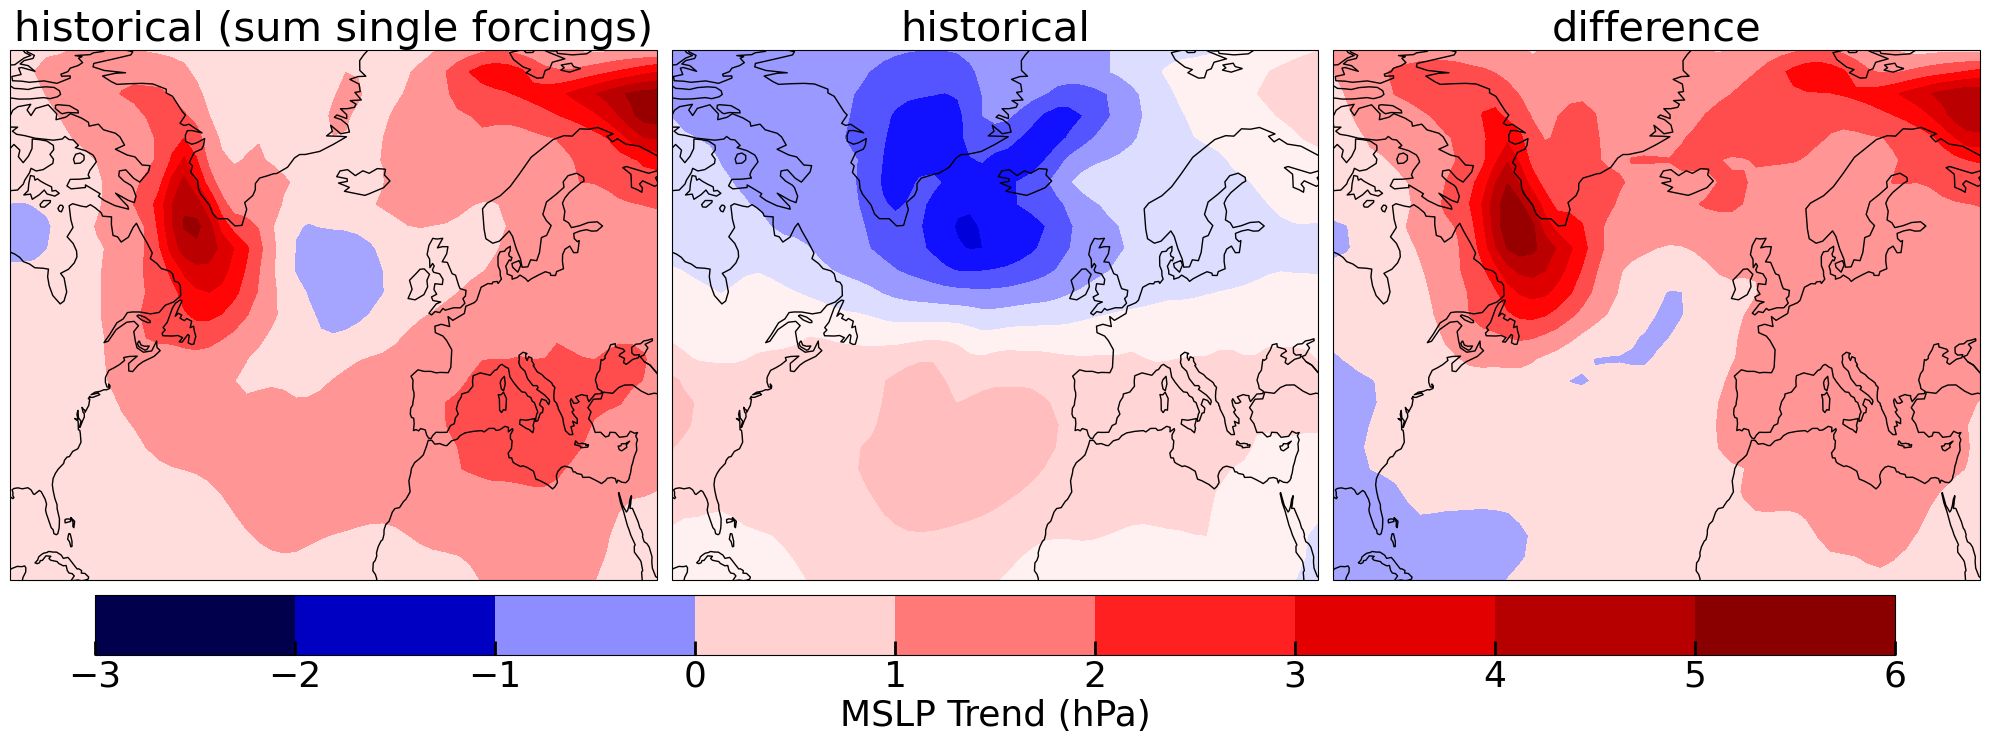

In [5]:
#PLOTTING - checking additivity

# Define the forcings
experiments = ['hist-aer', 'hist-GHG', 'hist-sol', 'hist-totalO3', 'hist-volc']
model_name = 'HadGEM3-GC31-LL'  # if needed for dynamic filename generation

# Sum all individual forcings
historical_trend_sum = sum(trend_data[experiment] for experiment in experiments)

# Compute the difference
historical_trend_diff = historical_trend_sum - trend_data['historical']

# Set up the figure
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 6), subplot_kw={'projection': ccrs.PlateCarree()})
titles_additivity = [
    'historical (sum single forcings)',
    'historical',
    'difference'
]
data_to_plot = [
    historical_trend_sum,
    trend_data['historical'],
    historical_trend_diff
]

# Define levels (if needed)
#levels = np.linspace(min_all, max_all, 21)

# Plot
for i in range(3):
    cont = ax[i].contourf(
        data_to_plot[i]['lon'], 
        data_to_plot[i]['lat'], 
        data_to_plot[i]['slope'], 
        cmap=cmap, norm=norm_all),# levels=levels
    #)
    ax[i].set_title(titles_additivity[i], fontsize = 30)
    ax[i].set_xlabel('lon')
    ax[i].set_ylabel('lat')
    ax[i].add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
    ax[i].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax[i].set_aspect('auto')

# Add colorbar (reusing dummy contour is still fine)

cax = fig.add_axes([0.05, -0.1, 0.9, 0.1])
cbar = fig.colorbar(dummy_cont, cax=cax, orientation='horizontal')
cbar.set_label('MSLP Trend (hPa)', fontsize=26)
cbar.ax.tick_params(direction='in', length=10, width=2, labelsize=26)



plt.tight_layout()
plt.savefig(f'Comparing_historical_to_sum_{model[0]}.png', bbox_inches='tight')

/tmp/ipykernel_562/855566723.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,0.91,0.97])


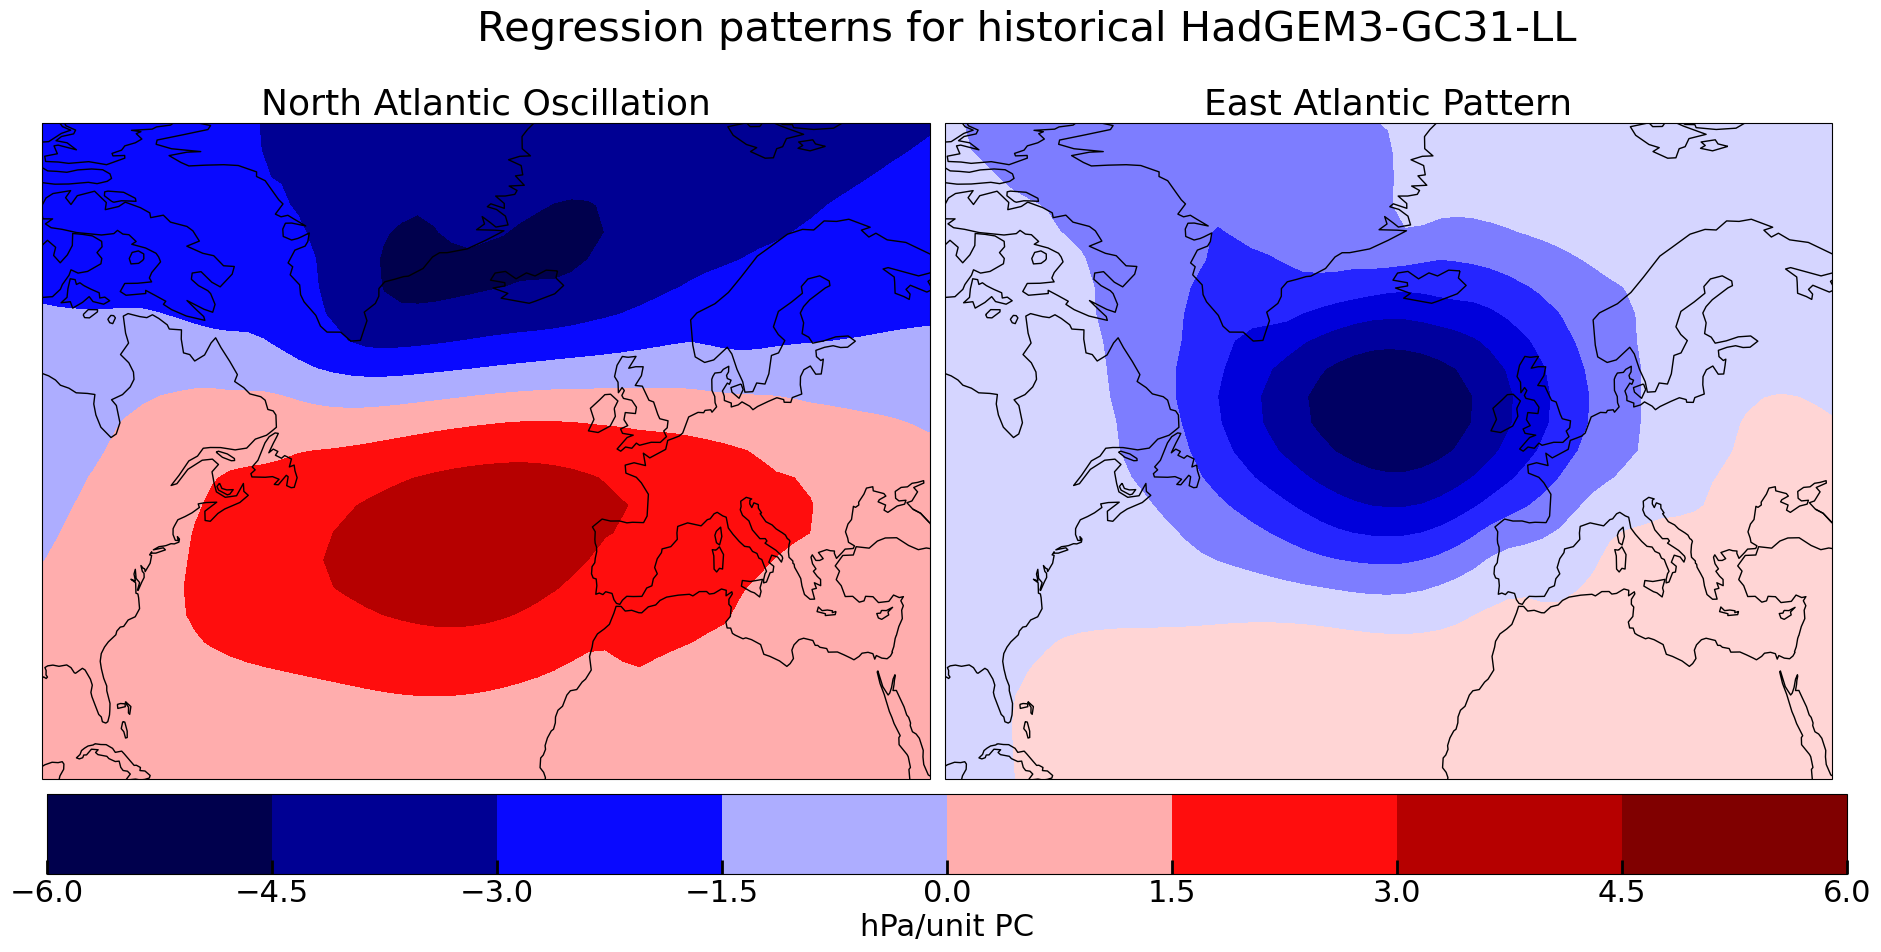

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8), subplot_kw={'projection': ccrs.PlateCarree()})
cmap = 'seismic'

NAO_EOF = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/regression_patterns/NAO/psl_mon_historical_HadGEM3-GC31-LL_DJF_NAO_regression_map.nc')
EA_EOF = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/regression_patterns/EA/psl_mon_historical_HadGEM3-GC31-LL_DJF_EA_regression_map.nc')

min_NAO = np.min(NAO_EOF['regression_NAO_djf'].values)
max_NAO = np.max(NAO_EOF['regression_NAO_djf'].values)

min_EA = np.min(EA_EOF['regression_EA_djf'].values)
max_EA = np.max(EA_EOF['regression_EA_djf'].values)

min_EOF = min(min_NAO, min_EA)
max_EOF = max(max_NAO, max_EA)

lon_NAO = NAO_EOF['lon'].values
lat_NAO = NAO_EOF['lat'].values

lon_EA = EA_EOF['lon'].values
lat_EA = EA_EOF['lat'].values

norm_EOF = mcolors.TwoSlopeNorm(vmin=min_EOF, vcenter=0, vmax=max_EOF)

dummy_data = np.array([[min_EOF, max_EOF], [min_EOF, max_EOF]])
dummy_cont = ax[0].contourf([0,1], [0,1], dummy_data, cmap=cmap, norm=norm_EOF)#, levels=levels)

# Map extent
lon_min, lon_max = -90, 40
lat_min, lat_max = 20, 80

# Plot
for i in range(2):
    #)
    ax[i].set_xlabel('lon')
    ax[i].set_ylabel('lat')
    ax[i].add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
    ax[i].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax[i].set_aspect('auto')

# Add colorbar (reusing dummy contour is still fine)

ax[0].contourf(lon_NAO, lat_NAO, (-1*NAO_EOF['regression_NAO_djf']).squeeze(), cmap=cmap, norm=norm_EOF, transform=ccrs.PlateCarree())
ax[1].contourf(lon_EA, lat_EA, EA_EOF['regression_EA_djf'].squeeze(), cmap=cmap, norm=norm_EOF, transform=ccrs.PlateCarree())

cax = fig.add_axes([0.01, -0.1, 0.9, 0.1])
cbar = fig.colorbar(dummy_cont, cax=cax, orientation='horizontal')
cbar.set_label('hPa/unit PC', fontsize=22)
cbar.ax.tick_params(direction='in', length=10, width=2, labelsize=22)
ax[0].set_title('North Atlantic Oscillation', fontsize=26)
ax[1].set_title('East Atlantic Pattern', fontsize=26)


# Add overall labels and title
fig.suptitle(f"Regression patterns for historical {model[0]}", fontsize=30)
plt.tight_layout(rect=[0,0,0.91,0.97])
plt.savefig(f'NAO_EA_regression_patterns_{model[0]}.png', bbox_inches='tight')
plt.show()

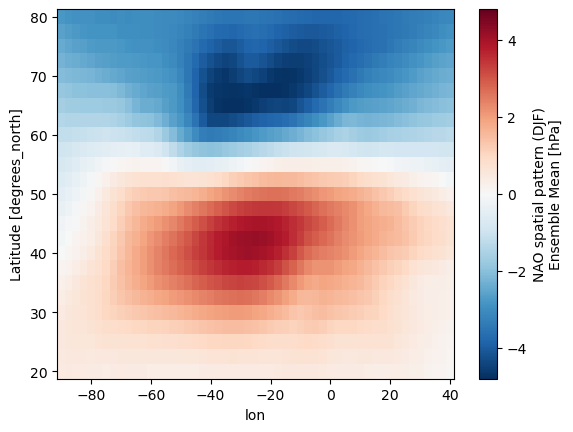

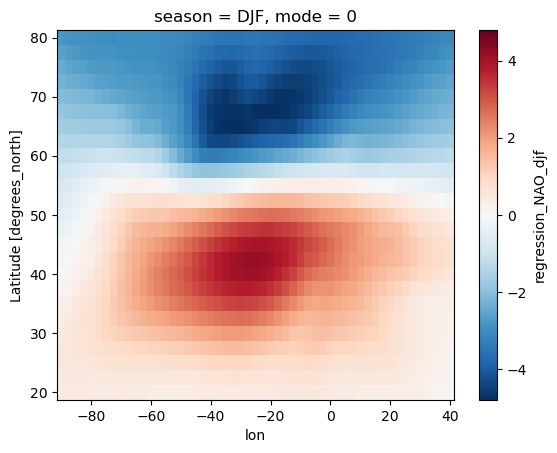

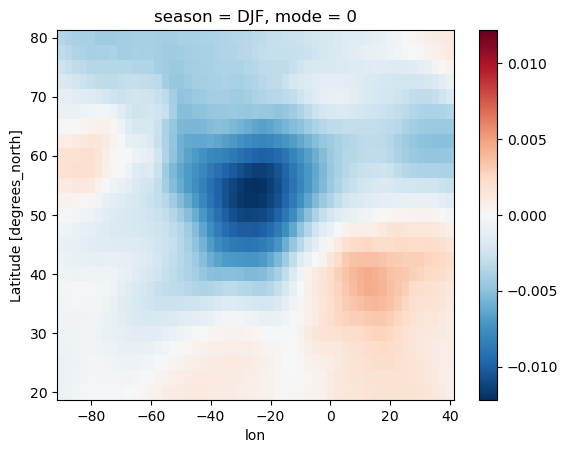

In [7]:
def CVDP_EM_crop_NA_sector(filename, pattern):
    #function which will crop the historical ensemble mean CVDP output to the NA sector
    ds = xr.open_dataset(filename)
    ds = ds[pattern]
    
    #finding the longitudes that are greater than 180
    new_lon = np.where(ds.lon > 179, ds.lon -360, ds.lon)
    
    #creating a copy of the data array where the longitudes have been shifted
    ds_shifted = ds.copy()
    ds_shifted.coords['lon'] = new_lon
    
    #Now need to make sure they are in the correct order and then re-index to make sure the lon get put to match the sorted lon
    sorted_lon = np.sort(ds_shifted.lon)
    ds_shifted = ds_shifted.sel(lon=sorted_lon)
    
    historical_NAO_EM_shifted = ds_shifted.sel(lat=slice(20,80), lon=slice(-90,40))

    return historical_NAO_EM_shifted


CVDP_filename = '/gws/nopw/j04/extant/users/slbennie/CVDP_outputs/NAO/historical/historical_NAO/HadGEM3-GC31-LL_EM.cvdp_data.nao.1850-2014.nc'
CVDP = CVDP_EM_crop_NA_sector(CVDP_filename, 'nao_pattern_djf_em')
CVDP.plot()
plt.show()
(-1*NAO_EOF['regression_NAO_djf']).plot()
plt.show()

(CVDP - (-NAO_EOF['regression_NAO_djf'])).plot()
plt.show()

/tmp/ipykernel_562/3419672148.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 0.95])


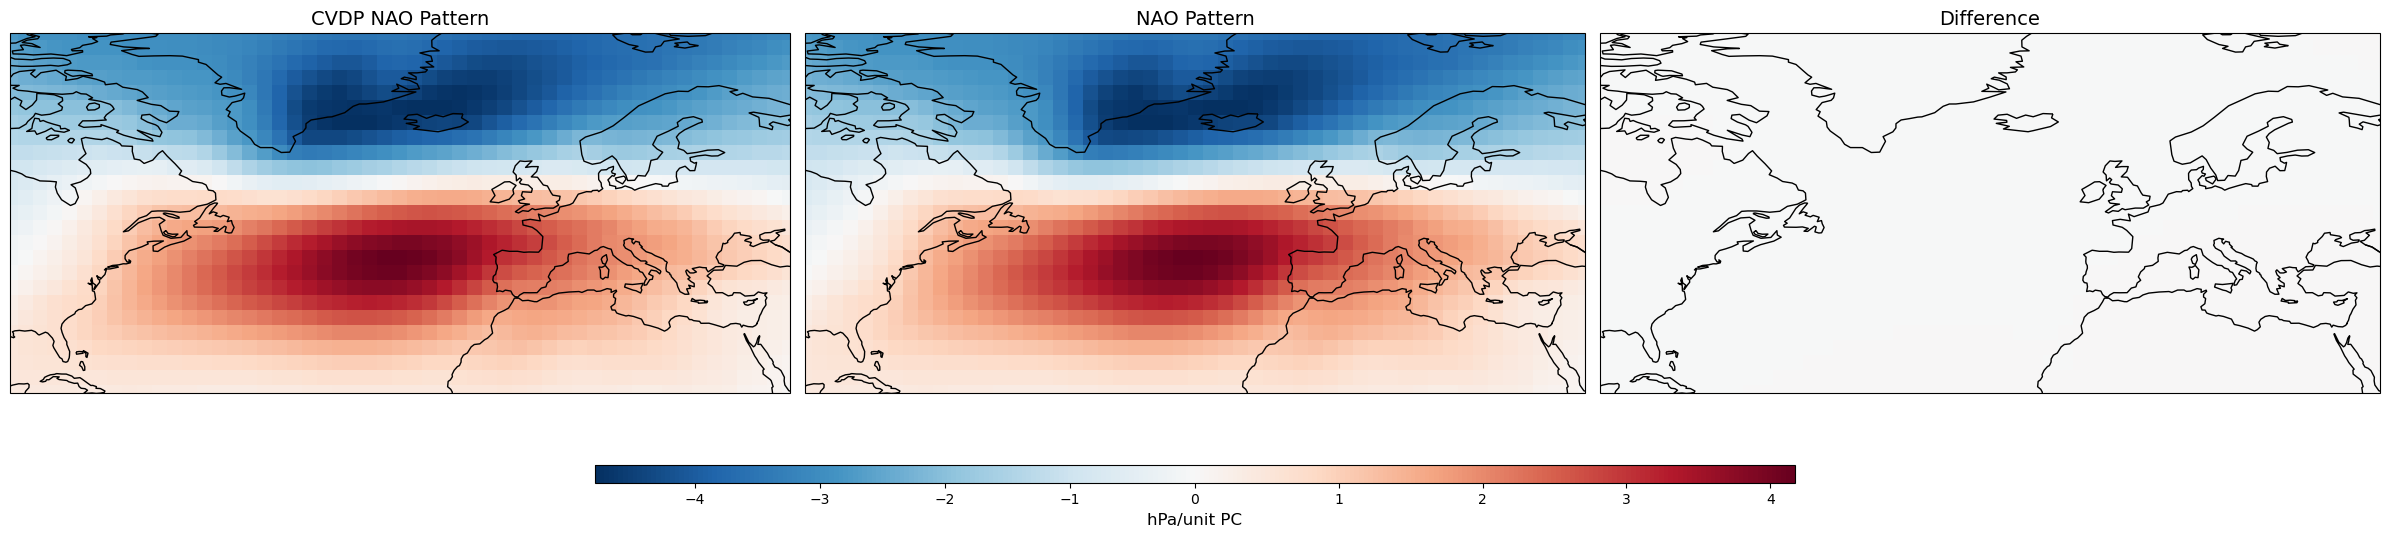

In [8]:
data1 = CVDP
data2 = -NAO_EOF['regression_NAO_djf']
data3 = data1 - data2

vmin = np.min([data1.min(), data2.min(), data3.min()])
vmax = np.max([data1.max(), data2.max(), data3.max()])

norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
cmap = 'RdBu_r'  # Or your preferred diverging colormap

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24, 6), subplot_kw={'projection': ccrs.PlateCarree()})

titles = ['CVDP NAO Pattern', 'NAO Pattern', 'Difference']
datasets = [data1, data2, data3]

for i, data in enumerate(datasets):
    im = axs[i].pcolormesh(data['lon'], data['lat'], data.squeeze(), cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    axs[i].set_title(titles[i], fontsize=14)
    axs[i].add_feature(cfeature.COASTLINE)
    axs[i].set_extent([-90, 40, 20, 80], crs=ccrs.PlateCarree())

# Shared colorbar
cbar_ax = fig.add_axes([0.25, 0.1, 0.5, 0.03])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('hPa/unit PC', fontsize=12)

plt.tight_layout(rect=[0, 0.15, 1, 0.95])
plt.show()


/tmp/ipykernel_562/2276401319.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,0.91,0.97])


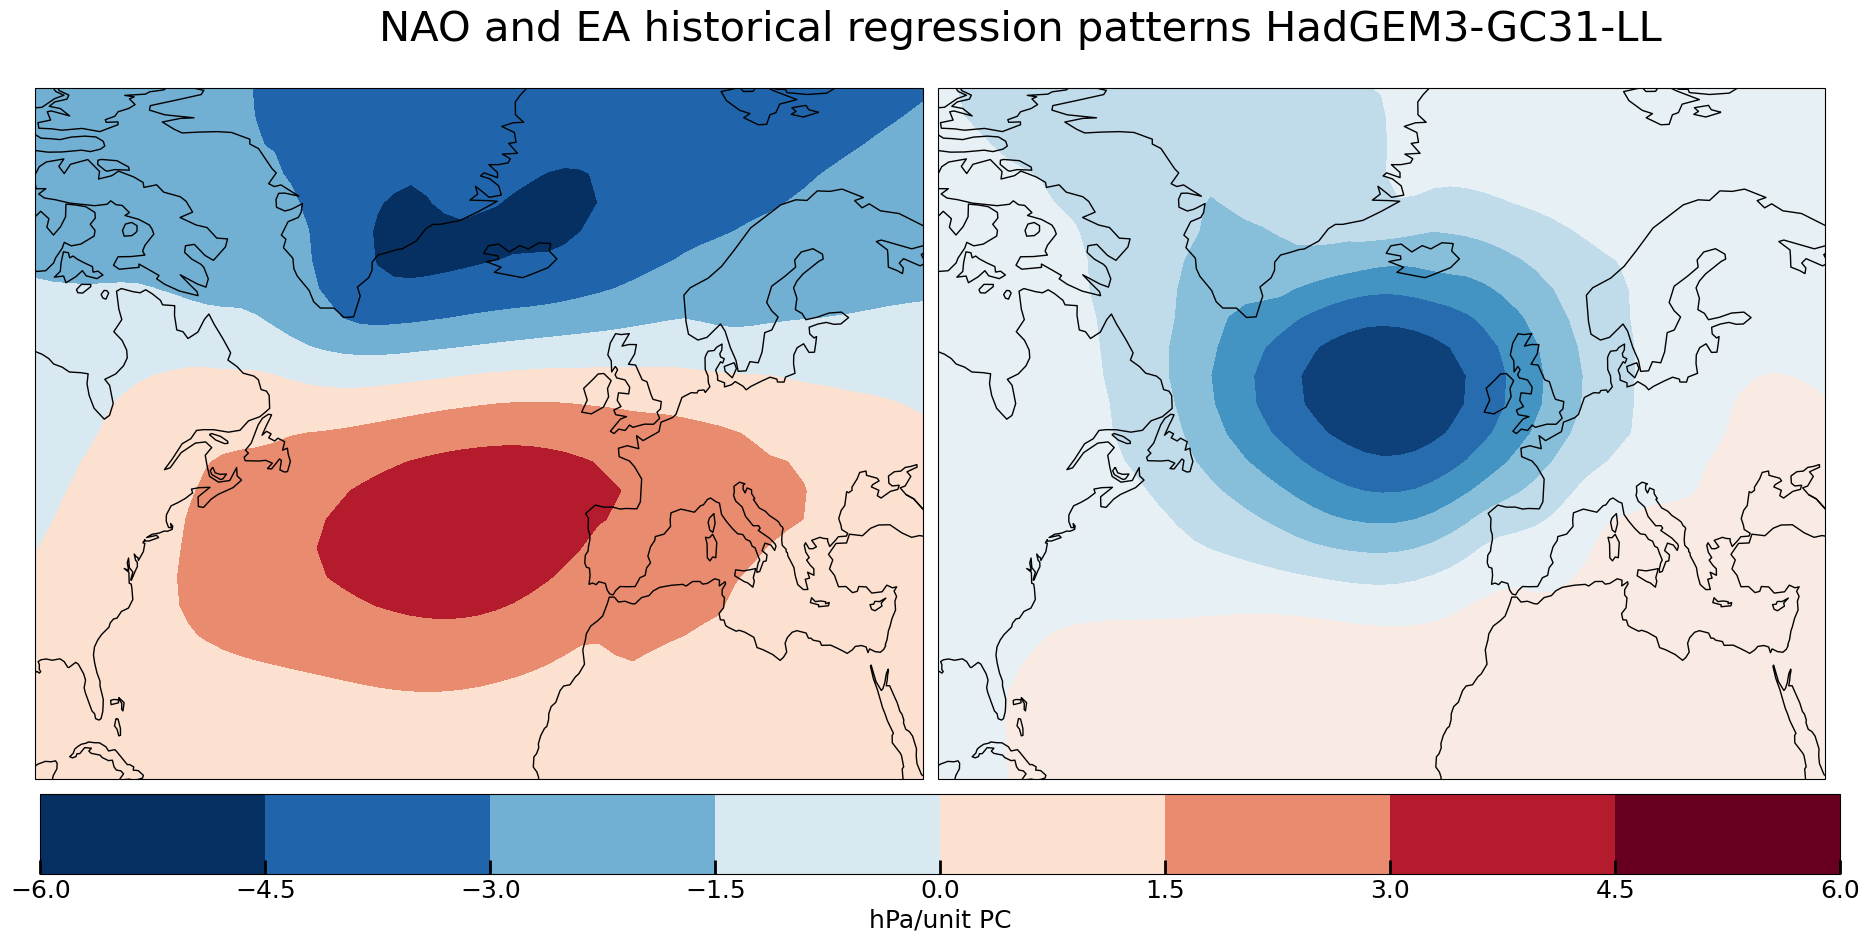

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8), subplot_kw={'projection': ccrs.PlateCarree()})

NAO_EOF = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/regression_patterns/NAO/psl_mon_historical_HadGEM3-GC31-LL_DJF_NAO_regression_map.nc')
EA_EOF = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/regression_patterns/EA/psl_mon_historical_HadGEM3-GC31-LL_DJF_EA_regression_map.nc')

min_NAO = np.min(NAO_EOF['regression_NAO_djf'].values)
max_NAO = np.max(NAO_EOF['regression_NAO_djf'].values)

min_EA = np.min(EA_EOF['regression_EA_djf'].values)
max_EA = np.max(EA_EOF['regression_EA_djf'].values)

min_EOF = min(min_NAO, min_EA)
max_EOF = max(max_NAO, max_EA)

lon_NAO = NAO_EOF['lon'].values
lat_NAO = NAO_EOF['lat'].values

lon_EA = EA_EOF['lon'].values
lat_EA = EA_EOF['lat'].values

norm_EOF = mcolors.TwoSlopeNorm(vmin=min_EOF, vcenter=0, vmax=max_EOF)

dummy_data = np.array([[min_EOF, max_EOF], [min_EOF, max_EOF]])
dummy_cont = ax[0].contourf([0,1], [0,1], dummy_data, cmap=cmap, norm=norm_EOF)#, levels=levels)

# Map extent
lon_min, lon_max = -90, 40
lat_min, lat_max = 20, 80

# Plot
for i in range(2):
    #)
    ax[i].set_xlabel('lon')
    ax[i].set_ylabel('lat')
    ax[i].add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
    ax[i].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax[i].set_aspect('auto')

# Add colorbar (reusing dummy contour is still fine)

ax[0].contourf(lon_NAO, lat_NAO, (-1*NAO_EOF['regression_NAO_djf']).squeeze(), cmap=cmap, norm=norm_EOF, transform=ccrs.PlateCarree())
ax[1].contourf(lon_EA, lat_EA, EA_EOF['regression_EA_djf'].squeeze(), cmap=cmap, norm=norm_EOF, transform=ccrs.PlateCarree())

cax = fig.add_axes([0.01, -0.1, 0.9, 0.1])
cbar = fig.colorbar(dummy_cont, cax=cax, orientation='horizontal')
cbar.set_label('hPa/unit PC', fontsize=18)
cbar.ax.tick_params(direction='in', length=10, width=2, labelsize=18)

# Add overall labels and title
fig.suptitle(f"NAO and EA historical regression patterns {model[0]}", fontsize=30)
plt.tight_layout(rect=[0,0,0.91,0.97])
plt.savefig(f'NAO_EA_regression_patterns_{model[0]}.svg', bbox_inches='tight')
plt.show()

In [10]:
proj_data['historical']

<xarray.Dataset> Size: 11kB
Dimensions:             (lat: 25, lon: 53)
Coordinates:
  * lat                 (lat) float64 200B 20.0 22.5 25.0 ... 75.0 77.5 80.0
  * lon                 (lon) float64 424B -90.0 -87.5 -85.0 ... 35.0 37.5 40.0
    season              <U3 12B ...
    mode                int64 8B ...
Data variables:
    projection_NAO_djf  (lat, lon) float64 11kB 0.08132 0.08748 ... -0.5997

/tmp/ipykernel_562/2148881062.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,0.91,0.97])


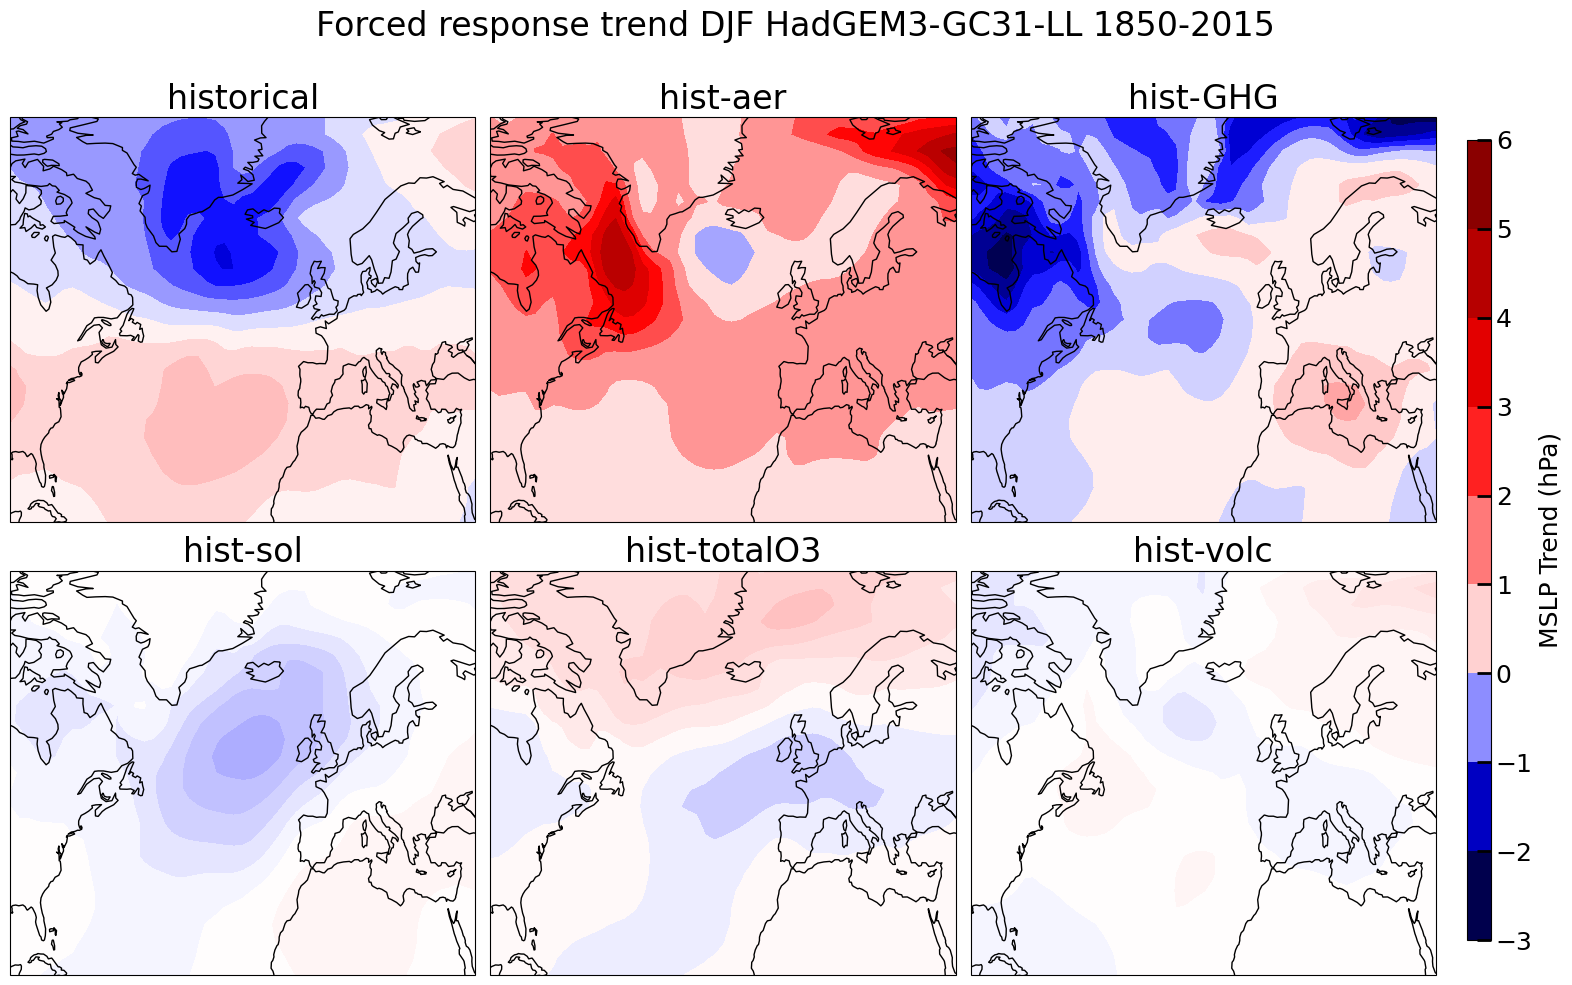

In [13]:
#PLOTTING - 5 row fig, trend, NAO part, residual 1, EA part, residual 2

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16,10), subplot_kw={'projection': ccrs.PlateCarree()})
cmap = 'seismic'
titles = ['historical','hist-aer','hist-GHG','hist-sol','hist-totalO3','hist-volc']

# Dummy colorbar setup
#max_abs = np.round(max(abs(min_all), abs(max_all)),1)
#levels = np.round(np.linspace(-max_abs, max_abs, 50),1)
dummy_data = np.array([[min_all, max_all], [min_all, max_all]])
dummy_cont = ax[0,0].contourf([0,1], [0,1], dummy_data, cmap=cmap, norm=norm_all)#, levels=levels)

# Map extent
lon_min, lon_max = -90, 40
lat_min, lat_max = 20, 80

# Plotting each row and column
for k in range(6):
    if k < 3:
        i = 0
        j = k
    else:
        i = 1
        j = k-3
    data = trend_data[titles[k]]
    ax[i,j].contourf(data['lon'], data['lat'], data['slope'], cmap=cmap, norm=norm_all)#, levels=levels)
    ax[i,j].set_title(titles[k], fontsize=24)

# Add coastlines and formatting
for i in range(2):
    for j in range(3):
        ax[i,j].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        ax[i,j].add_feature(cfeature.COASTLINE, linewidth=1)
        ax[i,j].set_xlabel('lon', fontsize=12)
        ax[i,j].set_ylabel('lat', fontsize=12)
        ax[i,j].set_aspect('auto')

# Add colorbar
cax = fig.add_axes([0.92, 0.05, 0.015, 0.8])
cbar = fig.colorbar(dummy_cont, cax=cax)
cbar.set_label('MSLP Trend (hPa)', fontsize=18)
cbar.ax.tick_params(direction='in', length=10, width=2, labelsize=18)
#cbar.locator = MaxNLocator(nbins=10)
#cbar.update_ticks()

# Add overall labels and title
fig.suptitle(f"Forced response trend DJF {model[0]} 1850-2015", fontsize=24)

plt.tight_layout(rect=[0,0,0.91,0.97])
plt.savefig(f'Forced_response_trend_{model[0]}.png', bbox_inches='tight')
plt.show()
